### Imports

In [ ]:
%pip install prophet
%pip install lifelines

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from prophet import Prophet
from lifelines import KaplanMeierFitter

#### 1. Config

In [ ]:
# CONFIG
TRAIN_END = 'd_1913'

DEPTS = ['HOBBIES_1', 'HOBBIES_2', 'FOODS_1',
       'FOODS_2', 'FOODS_3']

STORES = ['CA_1' ,'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
        'WI_2', 'WI_3']

THRESH = 10 # MAPE threshold

TEST_DAYS = 365

FORECAST_DAYS = 365 

WIN_SIZE_WEEKS = 4

STUDY_START_WEEKS = WIN_SIZE_WEEKS

STUDY_END_WEEKS = 26

SURVIVAL_PERCENTILE = 0.5

###1. Data Preprocessing

In [ ]:
sales = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/M5/sales_train_evaluation.csv')

In [ ]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [ ]:
sales.head().to_csv('M5_sales_head.csv')

In [ ]:
sales.dept_id.unique()

array(['HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS_1',
       'FOODS_2', 'FOODS_3'], dtype=object)

In [ ]:
# Filtering the departments in config
sales = sales[sales.dept_id.isin(DEPTS)]

In [ ]:
# sorting sales
sales = sales.sort_values(by=['item_id', 	'dept_id', 	'cat_id', 	'store_id',
                              'state_id'])

In [ ]:
# melting sales columns into one column
index_columns = ['id','item_id','dept_id','cat_id','store_id','state_id']
sales = pd.melt(sales, 
                  id_vars = index_columns, 
                  var_name = 'd', 
                  value_name = 'sales')

In [ ]:
# dropping unnecessary columns
sales = sales.drop(['cat_id','state_id','id'], axis=1)

In [ ]:
# rolling up item level data on store level
sales = sales.groupby(['dept_id','store_id','d']).agg({'sales':np.sum})\
.reset_index()

In [ ]:
# converting column 'd'  to int type for sorting
sales['d'] = [val.replace('d_','') for val in sales.d]
sales['d'] = pd.to_numeric(sales.d)
sales = sales.sort_values(by=['dept_id','store_id','d'], ignore_index=True)

In [ ]:
# select stores in config
stores = sales[sales.store_id.isin(STORES)]

### 3. Utilities for Survival Analysis

In [ ]:
def survival_mape_exp(df, win_size):
  '''Calculate expanding window mape for survival analysis.'''
  df['ape'] = np.abs((df['yhat'] - df['y'])/df['y'])*100
  df['exp_mape'] = df.ape.expanding(win_size).mean()
  df['survival_metric'] = df['exp_mape']
  return df


def survival_events(results):
  '''Generate events and censors for survival analysis.'''
  results = results[(results.index >= STUDY_START_WEEKS) & \
                    (results.index < STUDY_END_WEEKS)]
  thresh_res = results[results['survival_metric'] >= THRESH]
  
  # if some results are above threshold
  if len(thresh_res):

    # if all results are above thresh - this could be considered
    # as a case of left censorship - in our case we start evaluating
    # the model at STUDY_START_WEEKS and for this case it makes sense 
    # to force right censorship 
    if len(thresh_res) == len(results):
      thresh_week = STUDY_START_WEEKS
    else:
      thresh_week = thresh_res.index[0] + 1

    event = 1

  else:
    # event does not occur till the end of study
    thresh_week = STUDY_END_WEEKS
    event = 0

  return thresh_week, event

### 4. Building Forecast model

#### Prophet model

In [ ]:
def build_prophet(df):
  '''Build prophet model and generate events for survival modelling.'''
  # prepping data for prophet assuming data starts from Jan, 2015
  df['ds'] = pd.date_range(start='2015-01-01', periods=len(df))
  df['y'] = df.sales
  df = df[['ds','y']]

  # train/test splits
  train = df[:-TEST_DAYS]
  test = df[-TEST_DAYS:]
  
  model = Prophet(daily_seasonality=True)
  model.fit(train)
  future = model.make_future_dataframe(FORECAST_DAYS, include_history=False)
  forecast = model.predict(future)
  results = pd.merge(forecast, test, on='ds')

  # resample on weeks
  results = results.set_index('ds').resample('w').sum().reset_index()
  
  # generate metric suitable for survival analysis
  results_survival = survival_mape_exp(results, WIN_SIZE_WEEKS)

  # generate events and censors
  thresh_week, event = survival_events(results_survival)

       
  return pd.DataFrame({'thresh_week':[thresh_week], 'event':[event]})
  


#### For one store

In [ ]:
df = stores[stores.store_id.isin(['CA_1']) & stores.dept_id.isin(['FOODS_1'])].copy()
 # prepping data for prophet assuming data starts from Jan, 2015
df['ds'] = pd.date_range(start='2015-01-01', periods=len(df))
df['y'] = df.sales
df = df[['ds','y']]

# train/test splits
train = df[:-TEST_DAYS]
test = df[-TEST_DAYS:]

model = Prophet(daily_seasonality=True)
model.fit(train)
future = model.make_future_dataframe(FORECAST_DAYS, include_history=False)
forecast = model.predict(future)
results = pd.merge(forecast, test, on='ds')

# resample on weeks
results = results.set_index('ds').resample('w').sum().reset_index()

# generate metric suitable for survival analysis
results_survival = survival_mape_exp(results, WIN_SIZE_WEEKS)

# generate events and censors
thresh_week, event = survival_events(results_survival)

In [ ]:
results_survival['survival_metric']

0           NaN
1           NaN
2           NaN
3      6.679564
4      6.181303
5      7.179568
6      6.223449
7      6.413648
8      7.373657
9      9.477986
10     9.705403
11     9.741717
12    11.401585
13    12.716768
14    14.113945
15    14.385346
16    15.403248
17    16.736646
18    17.317952
19    17.539778
20    18.403450
21    19.615425
22    20.378087
23    21.335738
24    22.673245
25    23.292939
26    23.528185
27    25.142874
28    25.377737
29    25.680600
30    24.881361
31    25.497723
32    26.656850
33    26.837174
34    26.546049
35    26.657061
36    26.988421
37    27.543713
38    27.428419
39    28.068570
40    28.240560
41    28.064849
42    28.177369
43    28.278758
44    28.096966
45    28.676430
46    29.273824
47    29.798869
48    29.784768
49    29.546208
50    29.390554
51    29.355009
52    29.301213
Name: survival_metric, dtype: float64

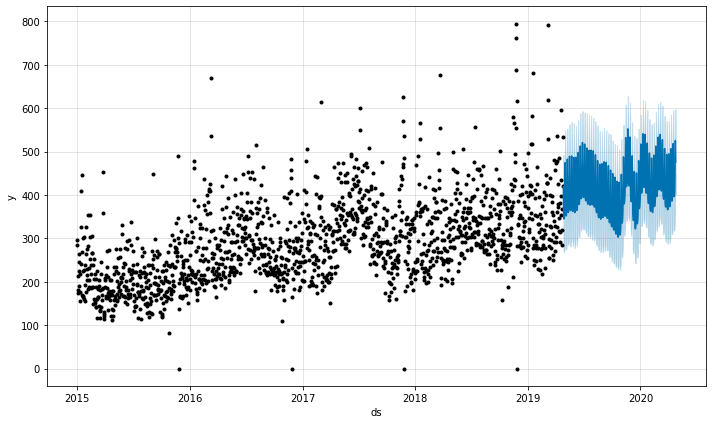

In [ ]:
model.plot(forecast)
plt.show()

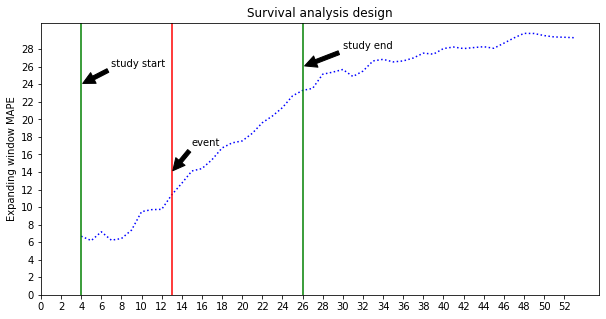

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax.plot(np.arange(1,len(results_survival)+1),\
        results_survival.survival_metric.values,\
        color = 'blue', marker = None,linestyle =':')
ax.set_ylabel('Expanding window MAPE')
ax.set_xticks(np.arange(0,len(results),2))
ax.set_yticks(np.arange(0,results.survival_metric.max(),2))
plt.axvline(x=STUDY_START_WEEKS, color='green')
plt.axvline(x=STUDY_END_WEEKS, color='green')
plt.axvline(x=thresh_week, color='red')
ax.set_title('Survival analysis design')
ax.annotate('study start', xy =(STUDY_START_WEEKS, 24),
                xytext =(7, 26), 
                arrowprops = dict(facecolor ='black',
                                  shrink = 0.05),)
ax.annotate('study end', xy =(STUDY_END_WEEKS, 26),
                xytext =(30, 28), 
                arrowprops = dict(facecolor ='black',
                                  shrink = 0.05),)
ax.annotate('event', xy =(thresh_week, 14),
                xytext =(15, 17), 
                arrowprops = dict(facecolor ='black',
                                  shrink = 0.05),)
plt.show()

#### For all stores

In [ ]:
results = stores.groupby(['dept_id', 'store_id']).apply(build_prophet).reset_index()

### KM model

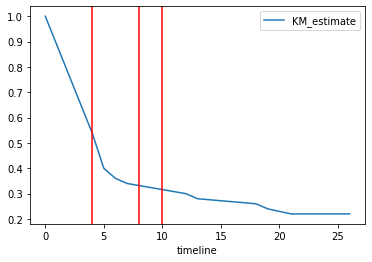

In [ ]:
kmf = KaplanMeierFitter()
kmf.fit(results.thresh_week, results.event)
kmf.survival_function_.plot()
f = plt.gcf()
plt.axvline(x=4, color='red')
plt.axvline(x=8, color='red')
plt.axvline(x=10, color='red')

plt.show()

HOBBIES
4.0
...
FOODS
4.0
...


/usr/local/lib/python3.7/dist-packages/lifelines/fitters/__init__.py:273: ApproximationWarning: Approximating using `survival_function_`. To increase accuracy, try using or increasing the resolution of the timeline kwarg in `.fit(..., timeline=timeline)`.

  exceptions.ApproximationWarning,
/usr/local/lib/python3.7/dist-packages/lifelines/fitters/__init__.py:273: ApproximationWarning: Approximating using `survival_function_`. To increase accuracy, try using or increasing the resolution of the timeline kwarg in `.fit(..., timeline=timeline)`.

  exceptions.ApproximationWarning,


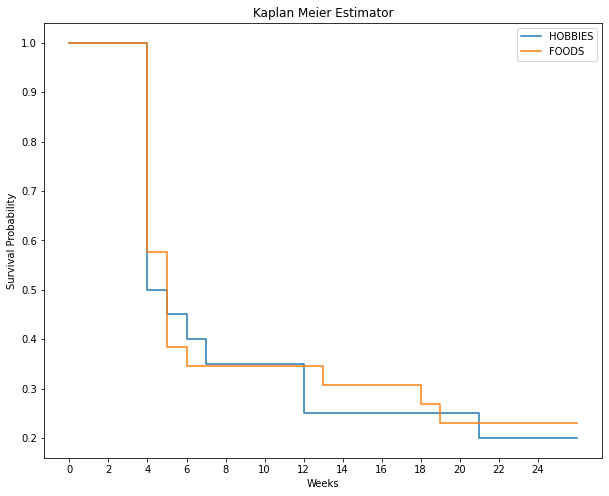

In [ ]:
# loop over each department type, fit KMF and visualize
fig, ax = plt.subplots(1,1,figsize=(10,8))
kmf = KaplanMeierFitter()
depts = ['HOBBIES', 'FOODS']
for dept in depts:
  depts_list = [d for d in results.dept_id.unique()\
                 if d.startswith(dept)]
  res_depts = results[results.dept_id.isin(depts_list)]
  kmf.fit(res_depts.thresh_week[:STUDY_END_WEEKS],\
          res_depts.event[:STUDY_END_WEEKS])
  kmf.plot(ax=ax, label = dept, ci_show=False)
  ax.legend()
  print(dept)
  #print(kmf.median_survival_time_)
  print(kmf.percentile(0.95))
  print('...')
  
ax.set_ylabel('Survival Probability')
ax.set_xlabel('Weeks')
ax.set_title('Kaplan Meier Estimator')
ax.set_xticks(np.arange(0,STUDY_END_WEEKS,2))
plt.show()

In [ ]:
kmf.percentile(0.5)

/usr/local/lib/python3.7/dist-packages/lifelines/fitters/__init__.py:273: ApproximationWarning: Approximating using `survival_function_`. To increase accuracy, try using or increasing the resolution of the timeline kwarg in `.fit(..., timeline=timeline)`.

  exceptions.ApproximationWarning,


5.0